# Import supporting package

In [203]:
import lmfit
import xarray as xr
import pandas as pd
import numpy as np
import copy

import glob

import xrft
import finufft

from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

from datetime import datetime

import matplotlib.pyplot as plt


plt.rcParams['font.size'] = 18

from scipy.ndimage import gaussian_filter
import matplotlib as mpl
from scipy.optimize import curve_fit
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)

from DataContainer.ReadData import read_hdf5_file, read_hdf5_global, read_hdf5_run_time, read_csv_file
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from Analyser.FitAnalyser import ThomasFermi2dModel, DensityProfileBEC2dModel, Polylog22dModel
from Analyser.FFTAnalyser import fft, ifft, fft_nutou
from ToolFunction.ToolFunction import *

import time

from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

imageAnalyser = ImageAnalyser()



In [243]:
# get center of thresholded image
def calc_thresh(data):
    shape = np.shape(data)
    thresh = np.zeros(shape)
    sigma = 0.4

    if len(shape) == 4:
        blurred = gaussian_filter(data, sigma=sigma)
        for i in range(0,shape[0]):
            for j in range(0, shape[1]):
                thresh[i,j] = np.where(blurred[i,j] < np.max(blurred[i,j])*0.3,0,1)

    elif len(shape) == 3:
        blurred = gaussian_filter(data, sigma=sigma)
        for i in range(0,shape[0]):
                thresh[i] = np.where(blurred[i] < np.max(blurred[i])*0.5,0,1)

    else:
        print("Shape of data is wrong, output is empty")

    return thresh

def calc_cen(thresh1):
    """
    returns array: [Y_center,X_center]
    """
    cen = np.zeros(2)
    (Y,X) = np.shape(thresh1)


    thresh1 = thresh1 /np.sum(thresh1)

    # marginal distributions
    dx = np.sum(thresh1, 0)
    dy = np.sum(thresh1, 1)

    # expected values
    cen[0] = np.sum(dx * np.arange(X))
    cen[1] = np.sum(dy * np.arange(Y))
    return cen

def calc_cen_bulk(thresh):
    """
    returns array in shape of input, containing array with [Y_center,X_center] for each image
    """
    shape = np.shape(thresh)
    cen = np.zeros((shape[0], shape[1], 2))
    for i in range(0, shape[0]):
        for j in range(0, shape[1]):
            cen[i,j] = calc_cen(thresh[i,j])
    return cen

def guess_BEC_width(thresh, center):
    """
    returns width of thresholded area along both axis through the center with shape of thresh and [X_width, Y_width] for each image
    """
    shape = np.shape(thresh)
    BEC_width_guess = np.zeros((shape[0], shape[1], 2))

    for i in range(0, shape[0]):
        for j in range(0, shape[1]):
            BEC_width_guess[i, j, 0] = np.sum(thresh[i, j, round(center[i,j,1]), :])
            BEC_width_guess[i, j, 1] = np.sum(thresh[i, j, :, round(center[i,j,0])])

    return BEC_width_guess



def gaussian(x, x0, sigma, A):
    return A * np.exp(-0.5 * (x-x0)**2 / sigma**2)

# def polylog(power, numerator, order = 15):
#
#     dataShape = numerator.shape
#     numerator = np.tile(numerator, (order, 1))
#     numerator = np.power(numerator.T, np.arange(1, order+1)).T
#
#     denominator = np.arange(1, order+1)
#     denominator = np.tile(denominator, (dataShape[0], 1))
#     denominator = denominator.T
#
#     data = numerator/ np.power(denominator, power)
#
#     return np.sum(data, axis=0)

def thermal(x, x0, amp, sigma):
    res = np.exp(-0.5 * (x-x0)**2 / sigma**2)
    return amp/1.643 * polylog(2, res)

def Thomas_Fermi_1d(x, x0, amp, sigma):
    res = (1-(( x - x0 ) / sigma) **2) **(3/2)
    return amp * np.where(res > 0, res, 0)

def density_1d(x, x0_bec, x0_th, amp_bec, amp_th, sigma_bec, sigma_th):
    return thermal(x, x0_th, amp_th, sigma_th) + Thomas_Fermi_1d(x, x0_bec, amp_bec, sigma_bec)


def polylog(pow, x):
    order = 15
    sum = 0
    for k in range(1,order):
        sum  += x ** k /k **pow
    return sum


def ThomasFermi_2d(x, y=0.0, centerx=0.0, centery=0.0, amplitude=1.0, sigmax=1.0, sigmay=1.0):
    res = (1- ((x-centerx)/(sigmax))**2 - ((y-centery)/(sigmay))**2)**(3 / 2)
    return amplitude * np.where(res > 0, res, 0)
    # return amplitude * 5 / 2 / np.pi / max(tiny, sigmax * sigmay) * np.where(res > 0, res, 0)


    # return amplitude / 2 / np.pi / 1.20206 / max(tiny, sigmax * sigmay) * polylog(2, np.exp( -((x-centerx)**2/(2 * (sigmax)**2))-((y-centery)**2/( 2 * (sigmay)**2)) ))


def density_profile_BEC_2d(x, y=0.0, amp_bec=1.0, amp_th=1.0, x0_bec=0.0, y0_bec=0.0, x0_th=0.0, y0_th=0.0,
                           sigmax_bec=1.0, sigmay_bec=1.0, sigmax_th=1.0, sigmay_th=1.0):
    return ThomasFermi_2d(x=x, y=y, centerx=x0_bec, centery=y0_bec,
                          amplitude=amp_bec, sigmax=sigmax_bec, sigmay=sigmay_bec
                          ) + polylog2_2d(x=x, y=y, centerx=x0_th, centery=y0_th,
                                          amplitude=amp_th, sigmax=sigmax_th, sigmay=sigmay_th)

In [22]:
def polylog2_2d(x, y=0.0, centerx=0.0, centery=0.0, amplitude=1.0, sigmax=1.0, sigmay=1.0):
    ## Approximation of the polylog function with 2D gaussian as argument. -> discribes the thermal part of the cloud
    return amplitude/1.643  * polylog_int(np.exp( -((x-centerx)**2/(2 * (sigmax)**2))-((y-centery)**2/( 2 * (sigmay)**2)) ))

In [20]:
# Set up table for polylog

def polylog_tab(pow, x):
    order = 100
    sum = 0
    for k in range(1,order):
        sum  += x ** k /k **pow
    return sum

x_int = np.linspace(0, 1.00001, 100000)

poly_tab = polylog_tab(2,x_int)

In [21]:
from scipy.interpolate import CubicSpline

polylog_int = CubicSpline(x_int, poly_tab)

In [19]:
x = 0.881
print(polylog_int(x))
print(polylog_tab(2, x))

1.2525003487835937
1.2525003487835928


In [151]:
# import data
img_dir = '//DyLabNAS/Data/'
SequenceName = "Evaporative_Cooling" + "/"
folderPath = img_dir + SequenceName + '2023/04/24'# get_date()


shotNum = "0009"
filePath = folderPath + "/" + shotNum + "/2023-04-24_0009_Evaporative_Cooling_*0.h5"



In [173]:
img_dir = '//DyLabNAS/Data/'
SequenceName = "Evaporative_Cooling" + "/"
folderPath = img_dir + SequenceName + '2023/04/17'# get_date()


shotNum = "import"
filePath = folderPath + "/" + shotNum + "/*.h5"

In [174]:

dataSet = read_hdf5_file(filePath, "images/MOT_3D_Camera/in_situ_absorption")
# flip the x and y axis
dataSet = swap_xy(dataSet)

# get the scan axis name of the shot
scanAxis = get_scanAxis(dataSet)

# calculate the absorption imaging
dataSet = imageAnalyser.get_absorption_images(dataSet)

OD = dataSet["OD"]

OD_np = OD.to_numpy()

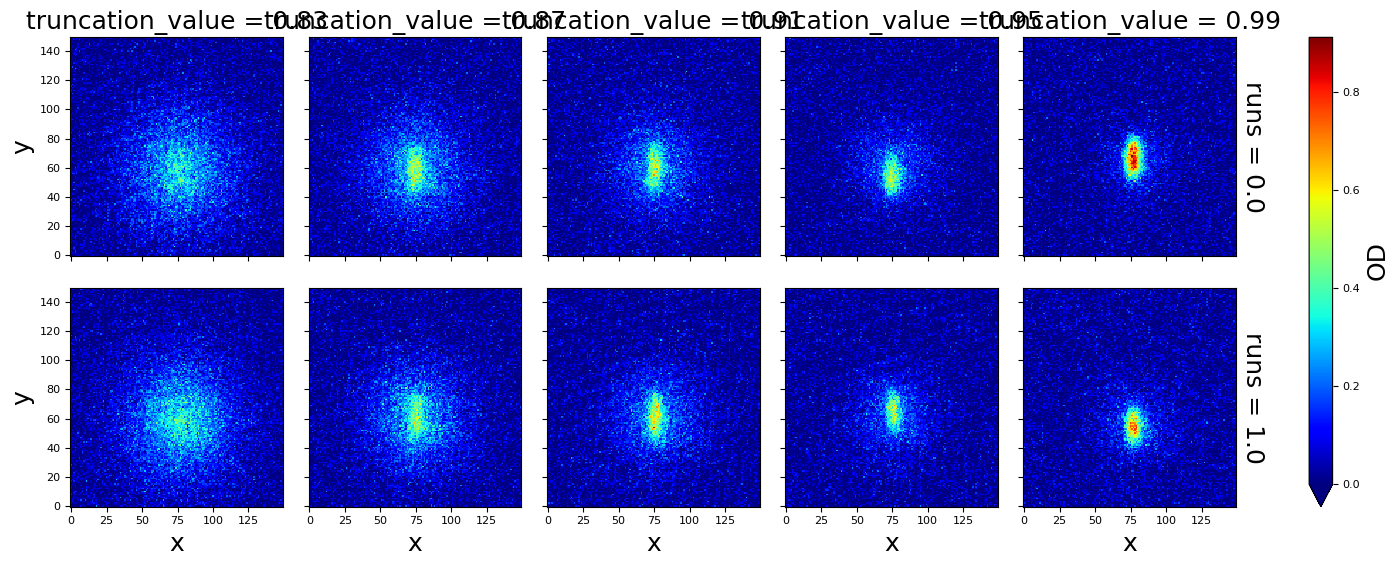

In [175]:
imageAnalyser.center = (960, 890)
imageAnalyser.span = (150, 150)
imageAnalyser.fraction = (0.1, 0.1)

dataSet_cropOD = imageAnalyser.crop_image(dataSet.OD)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()
cropOD = dataSet_cropOD.to_numpy()
dataSet_cropOD.plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[0], row=scanAxis[1])
plt.show()

In [245]:
# load Brittas data

data = np.zeros((2,11, 1200, 1920))
data[0] = np.load('Data_Britta/OD_ft_flatfield.npy')
data[1] = np.load('Data_Britta/OD_ft_manual.npy')

shape = np.shape(data)

In [246]:
cut_width = 250
thresh = calc_thresh(data)
center = calc_cen_bulk(thresh)

shape = np.shape(data)
cropOD = np.zeros((shape[0], shape[1], cut_width, cut_width))

for i in range(0,shape[0]):
    for j in range(0, shape[1]):
        cropOD[i,j] = data[i,j, round(center[i,j,1]-cut_width/2):round(center[i,j,1]+cut_width/2), round(center[i,j,0]-cut_width/2):round(center[i,j,0]+cut_width/2)]

thresh = calc_thresh(cropOD)
center = calc_cen_bulk(thresh)
# print(center)
BEC_width_guess = guess_BEC_width(thresh, center)


In [226]:
print(BEC_width_guess)


[[[19. 15.]
  [19. 18.]
  [24. 20.]
  [26. 23.]
  [26. 19.]
  [28. 23.]
  [26. 22.]
  [26. 25.]
  [25. 22.]
  [25. 20.]
  [30. 25.]]

 [[ 5.  3.]
  [ 9.  5.]
  [ 7.  9.]
  [10.  4.]
  [15. 13.]
  [22. 17.]
  [15. 15.]
  [ 7.  4.]
  [13. 12.]
  [19. 15.]
  [14. 12.]]]


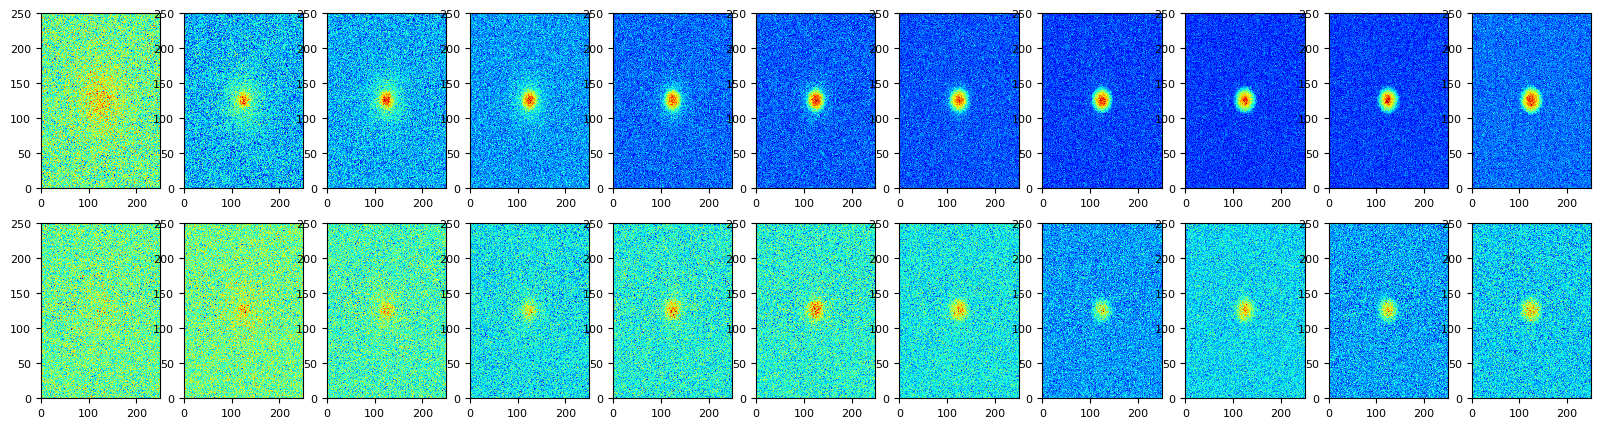

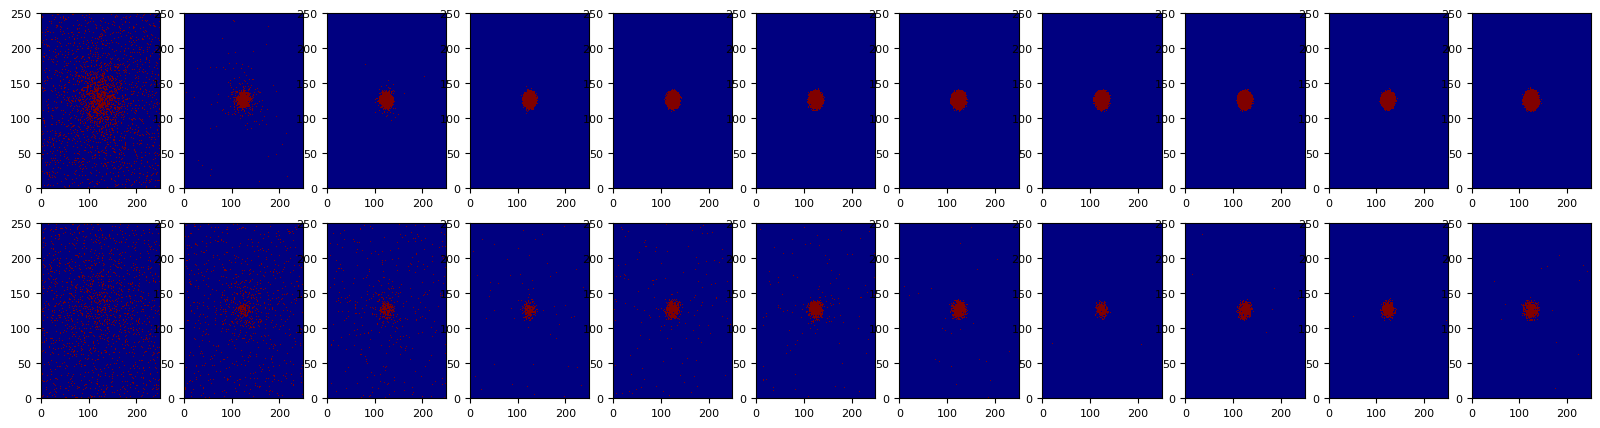

In [247]:
fig, ax = plt.subplots(shape[0],shape[1], figsize=(20,5))

for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        ax[i,j].pcolormesh(cropOD[i,j], cmap='jet')
        ax[i,j].plot(center[i,j,0], center[i,j,1])
plt.show()

fig, ax = plt.subplots(shape[0],shape[1], figsize=(20,5))

for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        ax[i,j].pcolormesh(thresh[i,j], cmap='jet')
plt.show()


In [248]:
# from opencv import moments
start = time.time()
shape = np.shape(cropOD)
sigma = 0.4
blurred = gaussian_filter(cropOD, sigma=sigma)

thresh = np.zeros(shape)
for i in range(0,shape[0]):
    for j in range(0, shape[1]):
        thresh[i,j] = np.where(blurred[i,j] < np.max(blurred[i,j])*0.5,0,1)

center = calc_cen_bulk(thresh)

BEC_width_guess = guess_BEC_width(thresh, center)

X_guess_og = np.zeros((shape[0], shape[1], shape[3]))
# Y_guess_og = np.zeros((shape[0], shape[1], shape[2]))

for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        X_guess_og[i,j] = np.sum(cropOD[i,j,round(center[i,j,1] - BEC_width_guess[i,j,1]/2) : round(center[i,j,1] + BEC_width_guess[i,j,1]/2) , :], 0) / len(cropOD[i,j,round(center[i,j,1] - BEC_width_guess[i,j,1]/2) : round(center[i,j,1] + BEC_width_guess[i,j,1]/2),0])

        # Y_guess_og[i,j] = np.sum(cropOD[i,j, :, round(center[i,j,0] - BEC_width_guess[i,j,0]/2) : round(center[i,j,0] + BEC_width_guess[i,j,0]/2)], 1) / len(cropOD[i,j,0,round(center[i,j,0] - BEC_width_guess[i,j,0]/2) : round(center[i,j,0] + BEC_width_guess[i,j,0]/2)])

#[nr images x, nr images y, X / Y, center / sigma]
x = np.linspace(0,shape[3],shape[3])
y = np.linspace(0,shape[2], shape[2])

popt = np.zeros((shape[0], shape[1], 6))

p0 = np.ones((shape[0], shape[1], 6))

max = np.zeros((shape[0], shape[1]))

for i in range(0, shape[0]):
    max[i] = np.ndarray.max(X_guess_og[i],axis=1)

# Fitting x without math constr
fitmodel = lmfit.Model(density_1d,independent_vars=['x'])

result_x = []

for i in range(0, shape[0]):
    temp_res = []
    for j in range(0, shape[1]):
        t1 = time.time()
        params = lmfit.Parameters()
        params.add_many(
            ('x0_bec', center[i,j,0], True,0, 200),
            ('x0_th',center[i,j,0], True,0, 200),
            ('amp_bec', 0.7 * max[i,j], True, 0, 1.3 * np.max(X_guess_og[i,j])),
            ('amp_th', 0.3 * max[i,j], True, 0, 1.3 * np.max(X_guess_og[i,j])),
            ('deltax', 70, True, 0,150),
            ('sigma_bec',BEC_width_guess[i,j,0]/1.22, True, 0, 50)
        )
        params.add('sigma_th', 3*BEC_width_guess[i,j,0], min=0, expr=f'0.632*sigma_bec + 0.518*deltax')

        t2 = time.time()
        res = fitmodel.fit(X_guess_og[i,j], x=x, params=params)
        t3 = time.time()
        temp_res.append(res)
        t4 = time.time()
        # print(t2 - t1)
        # print(t3 - t2)
        # print(t4 - t3)
        # print("")
    result_x.append(temp_res)
stop = time.time()

print(f'total time: {(stop-start)*1e3} ms')

total time: 1644.6044445037842 ms


In [241]:
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        print(result_x[i][j].best_values)

{'x0_bec': 119.96802214244894, 'x0_th': 127.63326165397993, 'amp_bec': 0.010428258179001615, 'amp_th': 0.09970108267412295, 'sigma_bec': 11.583362968593697, 'sigma_th': 38.31090265345486}
{'x0_bec': 125.05526628410517, 'x0_th': 125.00471649795092, 'amp_bec': 0.17310779365126494, 'amp_th': 0.1720820730247045, 'sigma_bec': 15.656355803721866, 'sigma_th': 27.064591004484093}
{'x0_bec': 124.87559149065213, 'x0_th': 124.75161622610302, 'amp_bec': 0.29524310149188965, 'amp_th': 0.1743190061268859, 'sigma_bec': 18.491463993335323, 'sigma_th': 26.355871715002863}
{'x0_bec': 125.0087031646933, 'x0_th': 124.76274722033101, 'amp_bec': 0.33449244741806405, 'amp_th': 0.2075912078840139, 'sigma_bec': 20.02281507393876, 'sigma_th': 21.82533112738463}
{'x0_bec': 125.14911780036935, 'x0_th': 125.19236477144689, 'amp_bec': 0.43441287165926823, 'amp_th': 0.2269965135606747, 'sigma_bec': 21.735511537553013, 'sigma_th': 19.6332649156627}
{'x0_bec': 125.19706330180884, 'x0_th': 124.78639501711406, 'amp_bec'

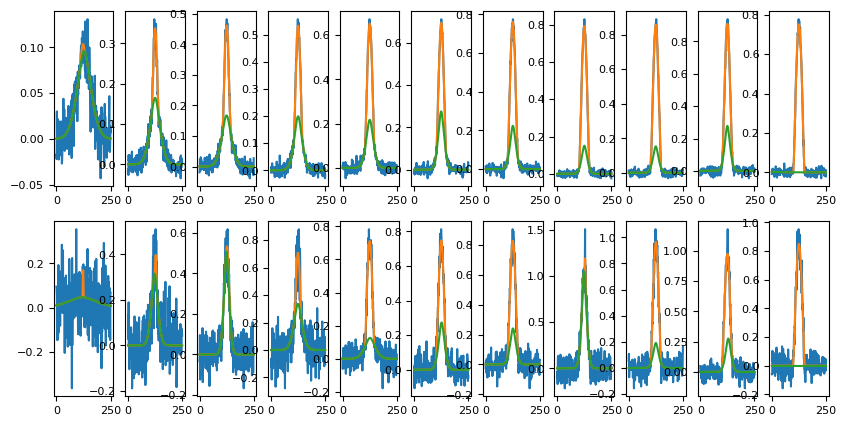

In [249]:
fsize= (10,5)
fig, ax = plt.subplots(shape[0],shape[1],figsize=fsize)
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        #lab = f"A$_{{BEC}}$ = {popt[i,j,0]:.1f} \n A$_{{th}}$ = {popt[i,j,1]:.1f} "
        bval = result_x[i][j].best_values
        ax[i,j].plot(x, X_guess_og[i,j])
        ax[i,j].plot(x, density_1d(x, **result_x[i][j].best_values))
        ax[i,j].plot(x, thermal(x, bval['x0_th'], bval['amp_th'], bval['sigma_th']))


plt.show()

## 2D Fit without mathematical constraint

In [236]:
result = []
times = []
x = np.linspace(0,shape[3],cut_width)
y = np.linspace(0,shape[2], cut_width)

for i in range(0,shape[0]):
    temp_res_arr = []
    for j in range(0,shape[1]):
        print(f'image {i},{j}')
        data = cropOD[i,j]
        fitModel = lmfit.Model(density_profile_BEC_2d, independent_vars=['x','y'])
        #fitModel.set_param_hint('deltax', value=5)

        bval_1d = result_x[i][j].best_values
        S = np.max(blurred[i,j])/(bval_1d['amp_bec'] + bval_1d['amp_th'])

        params = lmfit.Parameters()
        #print(bval['sigma_th'])
        params.add_many(
            ('amp_bec', S * bval_1d['amp_bec'], True, 0, 1.3 * np.max(data)),
            ('amp_th',S * bval_1d['amp_th'], True, 0, 1.3 * np.max(data)),
            ('x0_bec',center[i,j,0], True, 0, 150),
            ('y0_bec',center[i,j,1], True, 0, 150),
            ('x0_th',center[i,j,0], True, 0, 150),
            ('y0_th',center[i,j,1], True, 0, 150),
            ('sigmax_bec',bval_1d['sigma_bec'], True, 0, 50),
            ('sigmay_bec',BEC_width_guess[i,j,1], True, 0, 50),
            ('sigmax_th',bval_1d['sigma_th'], True, 0, 50),
            ('sigmay_th',bval_1d['sigma_th'],True, 0, 50)
        )

        X,Y = np.meshgrid(x, y)
        X_1d = X.flatten()
        Y_1d = Y.flatten()

        data1d = data.flatten()
        start = time.time()
        res = fitModel.fit(data1d, x=X_1d, y=Y_1d, params=params)
        stop = time.time()


        # Check if there is an thermal part
        bval = res.best_values
        tf_fit = ThomasFermi_2d(X,Y,centerx=bval['x0_bec'], centery=bval['y0_bec'], amplitude=bval['amp_bec'], sigmax=bval['sigmax_bec'], sigmay=bval['sigmay_bec'])
        tf_fit_2 = ThomasFermi_2d(X,Y,centerx=bval['x0_bec'], centery=bval['y0_bec'], amplitude=bval['amp_bec'], sigmax=3*bval['sigmax_bec'], sigmay=0.7*bval['sigmay_bec'])


        mask = np.where(tf_fit > 0, np.nan, data)
        #mask[i,j] = gaussian_filter(mask[i,j], sigma = 0.4)
        mask = np.where(tf_fit_2 > 0, mask, np.nan)

        check_value = np.nanmean(mask) / (bval["amp_bec"] + bval["amp_th"])

        print(stop-start)

        if check_value < 0.06:
            print('No thermal part detected, performing fit without thermal function')

            params = lmfit.Parameters()
            #print(bval['sigma_th'])
            params.add_many(
                ('amp_bec', S * bval_1d['amp_bec'], True, 0, 1.3 * np.max(data)),
                ('amp_th',0, False, 0, 1.3 * np.max(data)),
                ('x0_bec',center[i,j,0], True, 0, 150),
                ('y0_bec',center[i,j,1], True, 0, 150),
                ('x0_th', 1, False, 0, 150),
                ('y0_th', 1, False, 0, 150),
                ('sigmax_bec',bval_1d['sigma_bec'], True, 0, 50),
                ('sigmay_bec',BEC_width_guess[i,j,1], True, 0, 50),
                ('sigmax_th',1, False, 0, 50),
                ('sigmay_th',1,False, 0, 50)
            )

            start2 = time.time()
            res = fitModel.fit(data1d, x=X_1d, y=Y_1d, params=params)
            stop2 = time.time()

            print(stop2-start2)
            print('')
        stop2 = time.time()



        times.append(stop2-start)
        temp_res_arr.append(res)
    result.append(temp_res_arr)
times = np.array(times)
print(f"fitting time = {np.mean(times)} +- {np.std(times, ddof=1)}")
print(times)



image 0,0
1.9828362464904785
image 0,1
0.8513391017913818
image 0,2
0.47321081161499023
image 0,3
0.4963662624359131
image 0,4
0.4299449920654297
No thermal part detected, performing fit without thermal function
0.4895448684692383

image 0,5
0.49112844467163086
No thermal part detected, performing fit without thermal function
0.3686394691467285

image 0,6
0.4033057689666748
No thermal part detected, performing fit without thermal function
0.2928793430328369

image 0,7
0.49761414527893066
No thermal part detected, performing fit without thermal function
0.3190581798553467

image 0,8
0.5528171062469482
No thermal part detected, performing fit without thermal function
0.2500269412994385

image 0,9
0.6150035858154297
No thermal part detected, performing fit without thermal function
0.25365233421325684

image 0,10
3.0443363189697266
No thermal part detected, performing fit without thermal function
0.23251080513000488

image 1,0
2.122943878173828
image 1,1
1.3682045936584473
image 1,2
0.9506

C:\Users\Jianshun Gao\AppData\Local\Temp\ipykernel_23084\3332961138.py:52: RuntimeWarning: Mean of empty slice
  check_value = np.nanmean(mask) / (bval["amp_bec"] + bval["amp_th"])


0.4580409526824951
image 1,8
0.4922211170196533
image 1,9
0.8652794361114502
No thermal part detected, performing fit without thermal function
0.35244297981262207

image 1,10
0.6658725738525391
fitting time = 1.1354851831089368 +- 0.6755355329910758
[1.99731326 0.85931778 0.48119402 0.50334811 0.92949438 0.86870861
 0.70615792 0.82561731 0.81179214 0.88063955 3.28482533 2.13191938
 1.3761549  0.9586134  1.12814689 1.42925358 1.09293151 1.84848619
 0.46601868 0.49921441 1.22769547 0.67383122]


## Plotting

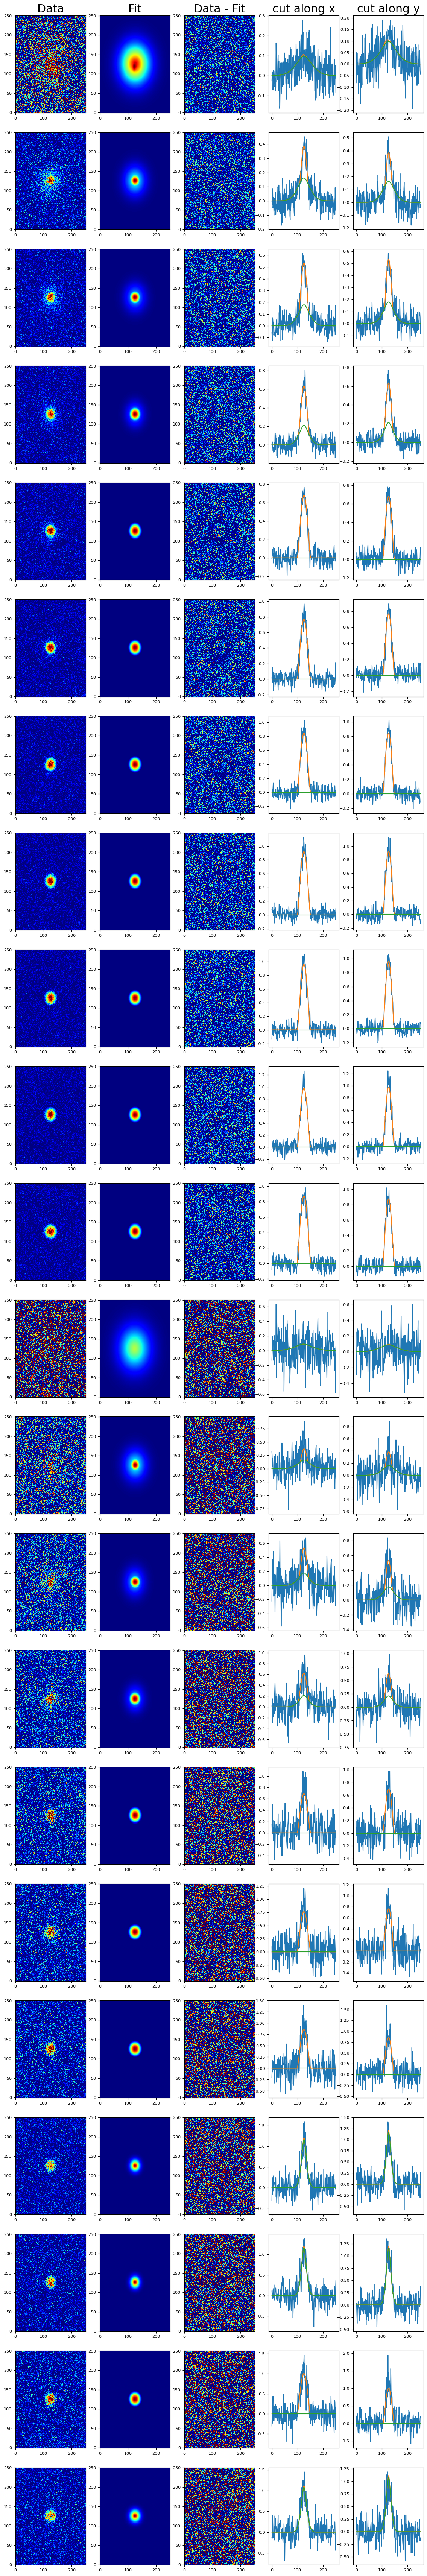

In [237]:
fig, axs = plt.subplots(shape[0] * shape[1], 5, figsize=(14, 4 * shape[0] * shape[1]))

ii = 0
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        bval = result[i][j].best_values
        fit = density_profile_BEC_2d(X,Y, **bval)
        vmax = np.max(fit)



        ax = axs[ii,0]
        ax.pcolormesh(X, Y, cropOD[i,j], vmin=0, vmax=vmax, cmap='jet', shading='auto')
        #plt.colorbar(art, ax=ax, label='z')


        # Plot gaussian 2d Fit + legend including Width parameters
        ax = axs[ii,1]

        ax.pcolormesh(X, Y, fit, vmin=0, vmax=vmax, cmap='jet', shading='auto')
        #plt.colorbar(art, ax=ax, label='z')

        ax = axs[ii,2]

        ax.pcolormesh(X, Y, fit-cropOD[i,j], vmin=0, vmax=0.2, cmap='jet', shading='auto')


        ax = axs[ii,3]

        ax.plot(x, cropOD[i,j, round(center[i,j,1]), :])
        ax.plot(x, fit[round(center[i,j,1]), :])
        ax.plot(x, thermal(x, bval['x0_th'], bval['amp_th'], bval['sigmax_th']))

        ax = axs[ii,4]

        ax.plot(y, cropOD[i,j, :, round(center[i,j,0])])
        ax.plot(y, fit[:, round(center[i,j,0])])
        ax.plot(x, thermal(y, bval['y0_th'], bval['amp_th'], bval['sigmay_th']))


        ii += 1

axs[0,0].set_title('Data')
axs[0,1].set_title('Fit')
axs[0,2].set_title('Data - Fit')
axs[0,3].set_title('cut along x')
axs[0,4].set_title('cut along y')

plt.show()

In [213]:
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        sx = result[i][j].best_values['sigmax_bec']
        sy = result[i][j].best_values['sigmay_bec']
        sx_th = result[i][j].best_values['sigmax_th']
        sy_th = result[i][j].best_values['sigmay_th']
        print(f'FWHM_x BEC: { sx*1.22:.2f}, FWHM_x thermal: { sx_th*1.93:.2f}')
        print(f'FWHM_y BEC: { sy*1.22:.2f}, FWHM_y thermal: { sy_th*1.93:.2f}')
        print('')

FWHM_x BEC: 33.90, FWHM_x thermal: 73.67
FWHM_y BEC: 2.42, FWHM_y thermal: 73.96

FWHM_x BEC: 20.60, FWHM_x thermal: 55.08
FWHM_y BEC: 18.21, FWHM_y thermal: 53.41

FWHM_x BEC: 23.76, FWHM_x thermal: 50.52
FWHM_y BEC: 20.31, FWHM_y thermal: 48.37

FWHM_x BEC: 32.58, FWHM_x thermal: 1.93
FWHM_y BEC: 29.32, FWHM_y thermal: 1.93

FWHM_x BEC: 31.51, FWHM_x thermal: 1.93
FWHM_y BEC: 27.95, FWHM_y thermal: 1.93

FWHM_x BEC: 31.36, FWHM_x thermal: 1.93
FWHM_y BEC: 27.45, FWHM_y thermal: 1.93

FWHM_x BEC: 31.52, FWHM_x thermal: 1.93
FWHM_y BEC: 27.42, FWHM_y thermal: 1.93

FWHM_x BEC: 31.04, FWHM_x thermal: 1.93
FWHM_y BEC: 27.34, FWHM_y thermal: 1.93

FWHM_x BEC: 31.25, FWHM_x thermal: 1.93
FWHM_y BEC: 26.98, FWHM_y thermal: 1.93

FWHM_x BEC: 31.14, FWHM_x thermal: 1.93
FWHM_y BEC: 26.82, FWHM_y thermal: 1.93

FWHM_x BEC: 33.19, FWHM_x thermal: 1.93
FWHM_y BEC: 28.35, FWHM_y thermal: 1.93

FWHM_x BEC: 0.12, FWHM_x thermal: 80.62
FWHM_y BEC: 59.15, FWHM_y thermal: 83.20

FWHM_x BEC: 19.94, FWH

sum = 1192.8121417540633, 0.15627970464401167
sum = 950.9154269641815, 0.08505242526623978
sum = 688.0487326402717, 0.06015579256809573
sum = 375.75843660247494, 0.032661144542309055
sum = 214.2438785702077, 0.012581635345426298
sum = 1552.8690227071345, 0.06318266674082226
sum = 930.8281141328514, 0.08800954618548565
sum = 620.9786516083725, 0.05060139414405358
sum = 388.8400181685539, 0.03559487481810801
sum = 372.0878928136244, 0.025825327683826803


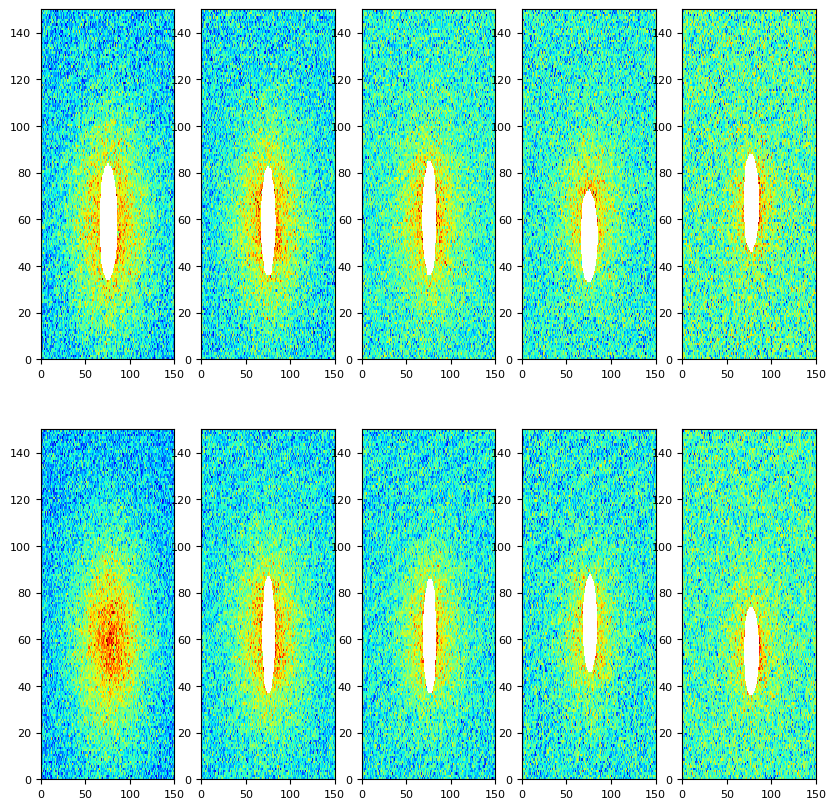

In [185]:
mask = np.zeros(shape)
mask2 = np.zeros(shape)
mask3 = []
fig, ax = plt.subplots(shape[0],shape[1], figsize=(10,10))

for i in range(0, shape[0]):
    temp_arr = []
    for j in range(0, shape[1]):
        arr = []
        bval = result[i][j].best_values
        tf_fit = ThomasFermi_2d(X,Y,centerx=bval['x0_bec'], centery=bval['y0_bec'], amplitude=bval['amp_bec'], sigmax=bval['sigmax_bec'], sigmay=bval['sigmay_bec'])
        tf_fit_2 = ThomasFermi_2d(X,Y,centerx=bval['x0_bec'], centery=bval['y0_bec'], amplitude=bval['amp_bec'], sigmax=3*bval['sigmax_bec'], sigmay=0.7*bval['sigmay_bec'])


        mask[i,j] = np.where(tf_fit > 0, np.nan, cropOD[i,j])
        #mask[i,j] = gaussian_filter(mask[i,j], sigma = 0.4)
        #mask[i,j] = np.where(tf_fit_2 > 0, mask[i,j], np.nan)
        mask2[i,j] = np.where(tf_fit > 0, np.nan, cropOD[i,j])
        # print(f'max = {np.nanmax(mask[i,j])}, {np.nanmax(mask[i,j]) / np.nanmin(mask[i,j])}')

        print(f'sum = {np.nansum(mask[i,j])}, {np.nanmean(mask[i,j]) / (bval["amp_bec"] + bval["amp_th"]) }')

        ax[i,j].pcolormesh(mask[i,j], cmap='jet')
        # print(f'mean = {np.nanmean(mask[i,j])}, {np.nanmean(mask2[i,j])}, {np.nanmean(mask[i,j]) / np.nanmean(mask2[i,j])}')
        # print(f'std = {np.nanstd(mask[i,j])}')
        # print()

        # frac = 1
        # temp_res = mask[i,j, round(bval['y0_bec'] - frac * bval['sigmay_bec']) : round(bval['y0_bec'] + frac * bval['sigmay_bec']),:]
        # temp_1d = np.nansum(temp_res, axis=0)
        #
        # print(f'sum = {np.nansum(temp_1d) / np.max(cropOD[i,j])}')
        # print(f'sum = {np.nanmax(temp_1d)/np.max(cropOD[i,j])}')
        #
        # plt.pcolormesh(temp_res, cmap='jet')
        # plt.show()
        # plt.plot(temp_1d)
        # plt.show()


plt.show()

In [184]:
result[1][0]